<h1>Synthetic Lethality Interaction Network</h1>

<p>The purpose of this notebook is to present the synthetic lethal interaction (SLI) network, which consists of our biocurated SLI data linked to <a href="https://string-db.org/" target=__blank>STRING</a> 
protein-protein interaction network. Graph operations are performed with <a href="https://github.com/AnacletoLAB/grape" target=__blank>GRAPE</a>.</p>
<p>For this knowledge graph, we combine a graph consisting of literature-curated SLIs from the 
<a href="https://github.com/monarch-initiative/SLDBGen" target="__blank">SLDBGen</a>
project and protein-protein interaction (PPI) data from <a href="https://string-db.org/" target=__blank>STRING</a>.</p>
<p>This notebook demonstrates the degree distribution and some other characteristics of this knowledge graph.</p>


In [1]:
from grape.datasets.kghub import SLDB
from grape.datasets.string import HomoSapiens
from grape import GraphVisualizer
import pandas as pd
import networkx as nx
from collections import Counter, defaultdict
from operator import itemgetter
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from IPython.display import HTML

<h2>Data import</h2>
<p>We import the SLI dataset and the STRING dataset using automatic import functions of 
<a href="https://github.com/AnacletoLAB/grape" target=__blank>GraPE</a> 
(Graph Processing and Embedding), a fast graph processing and embedding library.</p>

In [2]:
sldb = SLDB()
stringGraph = HomoSapiens()

<h2>Preparing the  data</h2>
<p>The <tt>SLDB()</tt> or the <tt>HomoSapiens()</tt> command of GraPE creates a new local directory (<tt>graphs</tt>) into which it downloads 
the data for the graphs. Here, we map the node identifiers from both graphs to <a href="https://www.genenames.org/" target=__blank>HGNC</a> gene symbols so we can combine the graphs. STRING uses the <a href="http://ensembl.org/index.html" target=__blank>ensembl</a> identifiers for proteins (prefixed by the taxon id for Homo sapiens), and sldb uses the <a href="http://ensembl.org/index.html" target=__blank>ensembl</a> identifiers for genes.  The following commands show an excerpt of the data and connect the graphs.</p>

In [3]:
stringGraph.get_node_names()[0:5]

['9606.ENSP00000000233',
 '9606.ENSP00000000412',
 '9606.ENSP00000001008',
 '9606.ENSP00000001146',
 '9606.ENSP00000002125']

In [4]:
sldb.get_node_names()[0:5]

['ENSEMBL:ENSG00000146648',
 'ENSEMBL:ENSG00000197043',
 'ENSEMBL:ENSG00000100030',
 'ENSEMBL:ENSG00000134215',
 'ENSEMBL:ENSG00000113013']

<p>The following code maps the names from both sources to HGNC gene symbols. Note that We retrieve the string gene mapping that is downloaded by the above command to the local <tt>graphs</tt> directory.</p>
<p>The following code additionally removes edge weights and filters the STRING data to have a quality score of at least 700 (a commonly used threshold).</p>

In [5]:
path = "graphs/string/HomoSapiens/links.v11.5/9606.protein.info.v11.5.txt"
data = pd.read_csv(path, sep="\t")
remapping_string = dict(zip(data[data.columns[0]], data[data.columns[1]]))
string_graph = stringGraph \
    .remove_node_types() \
    .filter_from_names(min_edge_weight=700) \
    .remove_edge_weights() \
    .remap_from_node_names_map(remapping_string) \
    .set_all_node_types("Gene") \
    .set_all_edge_types("PPI") \
    .remove_disconnected_nodes()
string_graph.get_node_names()[0:5]

['C16orf70', 'CEP72', 'DNAH7', 'SGSM3', 'ZNF117']

<p>The following code maps the names of the SLDB graph to HGNC gene symbols.</p>

In [6]:
path = "graphs/kghub/SLDB/20220522/sldb/merged-kg_nodes.tsv"
data = pd.read_csv(path, sep="\t")
remapping_sli = dict(zip(data[data.columns[0]], data[data.columns[2]]))

# We load the SLI graph
sli_graph = SLDB() \
    .remap_from_node_names_map(remapping_sli) \
    .set_all_node_types("Gene") \
    .set_all_edge_types("SLI")
sli_graph.get_node_names()[0:5]

['TOMM70', 'C12orf43', 'ROR1', 'TMEM165', 'PLCH1']

<p>The following code creates a combined graph and retains the largest connected component. We will focus machine learning
on the SLI edges, so we create a subgraph with only the SLI part of this graph for future reference.</p>

In [7]:
%%time
# We create the composed graph
composite_graph = (sli_graph | string_graph) \
    .remove_components(top_k_components=1)

composite_graph.enable()

subgraph_of_interest = composite_graph.filter_from_names(
    edge_type_names_to_keep=["SLI"]
)

CPU times: user 2.76 s, sys: 1.34 s, total: 4.1 s
Wall time: 419 ms


<h2>Summary: STRING PPI graph </h2>
<p>GraPE outputs a summary of graph characteristics.</p>

In [8]:
string_graph

<div class="graph-report"><style>.graph-report li {margin: 0.5em 0 0.5em 0;}.graph-report .paragraph {text-align: justify;word-break: break-all;}.graph-report .small-columns {column-count: 4;column-gap: 2em;}.graph-report .medium-columns {column-count: 3;column-gap: 2em;}.graph-report .large-columns {column-count: 2;column-gap: 2em;}.graph-report .single-column {}@media only screen and (max-width: 600px) {.graph-report .small-columns {column-count: 1;}.graph-report .medium-columns {column-count: 1;}.graph-report .large-columns {column-count: 1;}}@media only screen and (min-width: 600px) and (max-width: 800px) {.graph-report .small-columns {column-count: 2;}.graph-report .medium-columns {column-count: 1;}.graph-report .large-columns {column-count: 1;}}@media only screen and (min-width: 800px) and (max-width: 1024px) {.graph-report .small-columns {column-count: 3;}.graph-report .medium-columns {column-count: 2;}.graph-report .large-columns {column-count: 1;}}</style><h2>HomoSapiens</h2><p class="paragraph">The undirected graph HomoSapiens has 16.81K homogeneous nodes and 252.95K homogeneous edges. The graph contains 98 connected components, with the largest one containing 16.58K nodes and the smallest one containing 2 nodes. The RAM requirements for the nodes and edges data structures are 1.40MB and 778.44KB respectively.</p><h3 style="margin: 1em 0 0 0;">Degree centrality</h3><p class="paragraph">The minimum node degree is 1, the maximum node degree is 747, the mode degree is 1, the mean degree is 30.09 and the node degree median is 13.</p><p class="paragraph">The nodes with the highest degree centrality are RPS27A (degree 747 and node type Gene), TP53 (degree 723 and node type Gene), UBA52 (degree 669 and node type Gene), UBC (degree 620 and node type Gene) and SRC (degree 572 and node type Gene).</p><h3 style="margin: 1em 0 0 0;">Node types</h3><p class="paragraph">The graph has a single node type, which is Gene. The RAM requirement for the node types data structure is 874.47KB.</p><h4 style="margin: 1em 0 0 0;">Homogeneous node types</h4><p class="paragraph">Homogeneous node types are node types that are assigned to all the nodes in the graph, making the node type relatively meaningless, as it adds no more information than the fact that the node is in the graph. The graph contains a homogeneous node type, which is Gene.</p><h3 style="margin: 1em 0 0 0;">Edge types</h3><p class="paragraph">The graph has a single edge type, which is PPI. The RAM requirement for the edge types data structure is 2.02MB.</p><h3 style="margin: 1em 0 0 0;">Topological Oddities</h3><p class="paragraph">A topological oddity is a set of nodes in the graph that <i>may be derived</i> by an error during the generation of the edge list of the graph and, depending on the task, could bias the results of topology-based models. In the following paragraph, we will describe the detected topological oddities.</p><h4 style="margin: 1em 0 0 0;">Node tuples</h4><p class="paragraph">A node tuple is a connected component composed of two nodes. We have detected 77 node tuples in the graph, involving a total of 154 nodes (0.92%) and 77 edges (0.02%). The detected node tuples are:</p><ul class="medium-columns"><li><p class="paragraph">Node tuple containing the nodes DHRS13 (node type Gene) and GLIPR1L2 (node type Gene).</p></li>
<li><p class="paragraph">Node tuple containing the nodes C2orf81 (node type Gene) and C7orf73 (node type Gene).</p></li>
<li><p class="paragraph">Node tuple containing the nodes ZC2HC1C (node type Gene) and SERPINB11 (node type Gene).</p></li>
<li><p class="paragraph">Node tuple containing the nodes <a href='https://www.ensembl.org/Gene/Summary?g=ENSG00000280108' target='_blank' title='Go to ENSEMBL to get more informations about ENSG00000280108'>ENSG00000280108</a> (node type Gene) and <a href='https://www.ensembl.org/Gene/Summary?g=ENSG00000261130' target='_blank' title='Go to ENSEMBL to get more informations about ENSG00000261130'>ENSG0000026

<h2>Summary: SLI graph </h2>  

In [9]:
sli_graph

<div class="graph-report"><style>.graph-report li {margin: 0.5em 0 0.5em 0;}.graph-report .paragraph {text-align: justify;word-break: break-all;}.graph-report .small-columns {column-count: 4;column-gap: 2em;}.graph-report .medium-columns {column-count: 3;column-gap: 2em;}.graph-report .large-columns {column-count: 2;column-gap: 2em;}.graph-report .single-column {}@media only screen and (max-width: 600px) {.graph-report .small-columns {column-count: 1;}.graph-report .medium-columns {column-count: 1;}.graph-report .large-columns {column-count: 1;}}@media only screen and (min-width: 600px) and (max-width: 800px) {.graph-report .small-columns {column-count: 2;}.graph-report .medium-columns {column-count: 1;}.graph-report .large-columns {column-count: 1;}}@media only screen and (min-width: 800px) and (max-width: 1024px) {.graph-report .small-columns {column-count: 3;}.graph-report .medium-columns {column-count: 2;}.graph-report .large-columns {column-count: 1;}}</style><h2>SLDB</h2><p class="paragraph">The undirected graph SLDB has 1.77K homogeneous nodes and 2.44K homogeneous edges. The graph contains 6 connected components, with the largest one containing 1.76K nodes and the smallest one containing 2 nodes. The RAM requirements for the nodes and edges data structures are 118.10KB and 7.34KB respectively.</p><h3 style="margin: 1em 0 0 0;">Degree centrality</h3><p class="paragraph">The minimum node degree is 1, the maximum node degree is 483, the mode degree is 1, the mean degree is 2.75 and the node degree median is 1.</p><p class="paragraph">The nodes with the highest degree centrality are MYC (degree 483 and node type Gene), VHL (degree 478 and node type Gene), RB1 (degree 280 and node type Gene), KRAS (degree 201 and node type Gene) and ATR (degree 80 and node type Gene).</p><h3 style="margin: 1em 0 0 0;">Node types</h3><p class="paragraph">The graph has a single node type, which is Gene. The RAM requirement for the node types data structure is 92.55KB.</p><h4 style="margin: 1em 0 0 0;">Homogeneous node types</h4><p class="paragraph">Homogeneous node types are node types that are assigned to all the nodes in the graph, making the node type relatively meaningless, as it adds no more information than the fact that the node is in the graph. The graph contains a homogeneous node type, which is Gene.</p><h3 style="margin: 1em 0 0 0;">Edge types</h3><p class="paragraph">The graph has a single edge type, which is SLI. The RAM requirement for the edge types data structure is 19.79KB.</p><h3 style="margin: 1em 0 0 0;">Topological Oddities</h3><p class="paragraph">A topological oddity is a set of nodes in the graph that <i>may be derived</i> by an error during the generation of the edge list of the graph and, depending on the task, could bias the results of topology-based models. In the following paragraph, we will describe the detected topological oddities.</p><h4 style="margin: 1em 0 0 0;">Node tuples</h4><p class="paragraph">A node tuple is a connected component composed of two nodes. We have detected 5 node tuples in the graph, involving a total of 10 nodes (0.56%) and 5 edges (0.10%). The detected node tuples are:</p><ul class="medium-columns"><li><p class="paragraph">Node tuple containing the nodes PARG (node type Gene) and DUSP22 (node type Gene).</p></li>
<li><p class="paragraph">Node tuple containing the nodes HK1 (node type Gene) and HK2 (node type Gene).</p></li>
<li><p class="paragraph">Node tuple containing the nodes DDR1 (node type Gene) and TMPRSS4 (node type Gene).</p></li>
<li><p class="paragraph">Node tuple containing the nodes GPI (node type Gene) and ALAD (node type Gene).</p></li>
<li><p class="paragraph">Node tuple containing the nodes PTPN11 (node type Gene) and TNK2 (node type Gene).</p></li></ul><h4 style="margin: 1em 0 0 0;">Isomorphic node groups</h4><p class="paragraph">Isomorphic groups are nodes with exactly the same neighbours and node types (if present in the graph). Nodes in such groups are topologically 

<h2>Summary: Composite graph </h2>  

In [10]:
composite_graph

<div class="graph-report"><style>.graph-report li {margin: 0.5em 0 0.5em 0;}.graph-report .paragraph {text-align: justify;word-break: break-all;}.graph-report .small-columns {column-count: 4;column-gap: 2em;}.graph-report .medium-columns {column-count: 3;column-gap: 2em;}.graph-report .large-columns {column-count: 2;column-gap: 2em;}.graph-report .single-column {}@media only screen and (max-width: 600px) {.graph-report .small-columns {column-count: 1;}.graph-report .medium-columns {column-count: 1;}.graph-report .large-columns {column-count: 1;}}@media only screen and (min-width: 600px) and (max-width: 800px) {.graph-report .small-columns {column-count: 2;}.graph-report .medium-columns {column-count: 1;}.graph-report .large-columns {column-count: 1;}}@media only screen and (min-width: 800px) and (max-width: 1024px) {.graph-report .small-columns {column-count: 3;}.graph-report .medium-columns {column-count: 2;}.graph-report .large-columns {column-count: 1;}}</style><h2>(SLDB | HomoSapiens)</h2><p class="paragraph">The undirected multigraph (SLDB | HomoSapiens) has 16.71K homogeneous nodes and 255.25K heterogeneous edges. The graph is connected, that is, it is composed of a single connected component that includes all nodes and edges. The RAM requirements for the nodes and edges data structures are 1.40MB and 784.38KB respectively.</p><h3 style="margin: 1em 0 0 0;">Degree centrality</h3><p class="paragraph">The minimum node degree is 1, the maximum node degree is 790, the mode degree is 1, the mean degree is 30.54 and the node degree median is 13.</p><p class="paragraph">The nodes with the highest degree centrality are MYC (degree 790 and node type Gene), TP53 (degree 760 and node type Gene), RPS27A (degree 749 and node type Gene), UBA52 (degree 669 and node type Gene) and UBC (degree 621 and node type Gene).</p><h3 style="margin: 1em 0 0 0;">Node types</h3><p class="paragraph">The graph has a single node type, which is Gene. The RAM requirement for the node types data structure is 869.43KB.</p><h4 style="margin: 1em 0 0 0;">Homogeneous node types</h4><p class="paragraph">Homogeneous node types are node types that are assigned to all the nodes in the graph, making the node type relatively meaningless, as it adds no more information than the fact that the node is in the graph. The graph contains a homogeneous node type, which is Gene.</p><h3 style="margin: 1em 0 0 0;">Edge types</h3><p class="paragraph">The graph has 2 edge types, which are PPI (505.62K edges, 99.04%) and SLI (4.89K edges, 0.96%). The RAM requirement for the edge types data structure is 2.04MB.</p><h3 style="margin: 1em 0 0 0;">Topological Oddities</h3><p class="paragraph">A topological oddity is a set of nodes in the graph that <i>may be derived</i> by an error during the generation of the edge list of the graph and, depending on the task, could bias the results of topology-based models. In the following paragraph, we will describe the detected topological oddities.</p><h4 style="margin: 1em 0 0 0;">Isomorphic node groups</h4><p class="paragraph">Isomorphic groups are nodes with exactly the same neighbours and node types (if present in the graph). Nodes in such groups are topologically indistinguishable, that is swapping their ID would not change the graph topology. We have detected 20 isomorphic node groups in the graph, involving a total of 44 nodes (0.26%) and 548 edges (0.11%), with the largest one involving 5 nodes and 95 edges. The detected isomorphic node groups, sorted by decreasing size, are:</p><ol class="medium-columns"><li><p class="paragraph">Group with 5 nodes (degree 19 and node type Gene): GALNT15, GALNT9, GALNT10, GALNT18 and GALNTL6.</p></li>
<li><p class="paragraph">Group with 2 nodes (degree 29 and node type Gene): FAM187A and CCDC103.</p></li>
<li><p class="paragraph">Group with 2 nodes (degree 21 and node type Gene): GALNT6 and GALNT4.</p></li>
<li><p class="paragraph">Group with 2 nodes (degree 18 and node type Gene): H2BFM and H2BFWT.</p>

<h2>Compare the network characteristics of the STRING and the SLI graphs</h2> 

<h3>visualize node degree distribution</h3>

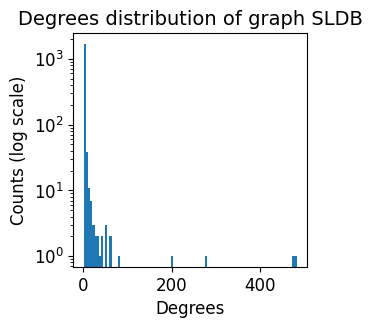

In [11]:
matplotlib.rc('font', size=12)
matplotlib.rc('axes', titlesize=14)
%matplotlib inline
#matplotlib.rc('figsize', size=(12,12))
visualizer = GraphVisualizer(sli_graph, automatically_display_on_notebooks=False)
fig, ax, cap = visualizer.plot_node_degree_distribution()
fig.set_figheight(3)
fig.set_figwidth(3)
#plt.savefig('sli_degree_distribution.pdf') 
plt.show()

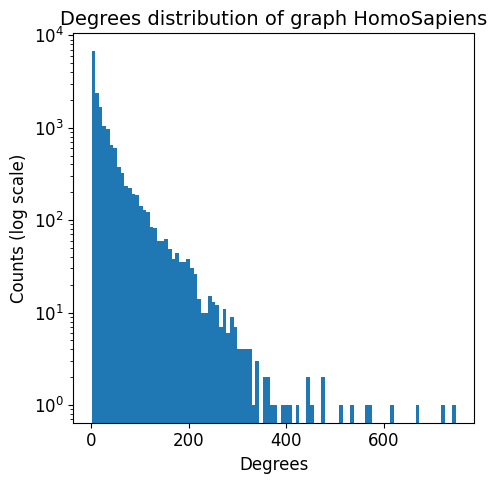

In [12]:
visualizer = GraphVisualizer(string_graph)
visualizer.plot_node_degree_distribution()
#plt.savefig('string_degree_distribution.pdf')  
plt.show();

<h2>Network characteristics</h2>
<p>Collect network characteristics from SLI, STRING, and composite and write them to a csv file.</p>

In [13]:
def get_network_characteristics(graph):
    """
    Calculate the network characteristics of the largest graph component
    Note that 
    The returned quadruple contains:
    - Vector of the connected component for each node.
    - Number of connected components.
    - Minimum connected component size.
    - Maximum connected component size.
    """
    d = {}
    cc = graph.get_number_of_connected_components()
    d['connected.components'] = cc[0]
    d['smallest_component_size'] = cc[1]
    d['largest_component_size]'] = cc[2]
    d['n_nodes_entire_graph'] = graph.get_number_of_nodes()
    d['n_edges_entire_graph'] = graph.get_number_of_edges()
    ## extract largest component
    g = graph.remove_components(top_k_components=1)
    d['n_nodes'] = g.get_number_of_nodes()
    d['n_edges'] = g.get_number_of_edges()
    d['diameter'] = g.get_diameter()
    d['clustering.coefficient'] = g.get_clustering_coefficient()
    d['density'] = g.get_density()
    d['get_node_degree_mean'] = g.get_node_degrees_mean()
    d['get_node_degree_median'] = g.get_node_degrees_median()
    d['get_node_degree_mode'] = g.get_node_degrees_mode()
    d['number_of_triangles'] = g.get_number_of_triangles()
    d['self_loops'] = g.get_number_of_selfloops()
    d['transitivity'] = g.get_transitivity()
    d['tendrils'] = len(g.get_tendrils())
    return d

In [14]:
sli_d = get_network_characteristics(sli_graph)
string_d = get_network_characteristics(string_graph)
composite_d = get_network_characteristics(composite_graph)

In [15]:
characteristics = []
for item in sli_d.keys():
    sli = str(sli_d.get(item))
    strng = str(string_d.get(item))
    compt = str(composite_d.get(item))
    d = {"name":item, "SLI":sli, "STRING":strng, "Composite":compt}
    characteristics.append(d)
df = pd.DataFrame(characteristics)
df.set_index('name',inplace=True)
# df.to_csv("network_characteristics.csv")
df.head(40)

,SLI,STRING,Composite
name,,,
connected.components,6,98,1
smallest_component_size,2,2,16715
largest_component_size],1765,16582,16715
n_nodes_entire_graph,1775,16812,16715
n_edges_entire_graph,2445,252953,255253
n_nodes,1765,16582,16715
n_edges,2440,252802,255253
diameter,9.0,14.0,14.0
clustering.coefficient,58.40051374792566,5617.585994213559,5588.587964382149


<h1>Synthetic Lethal Network Visualization</h1>
<p>Visualizations and characterizations of the SLDB network.</p>

In [16]:
n_nodes = sli_graph.get_number_of_nodes()
print(f"The SLI network has {n_nodes} nodes")

The SLI network has 1775 nodes


<h2>Show nodes by degree</h2>
<p>The SLI network is characterized by a skewed degree distribution. Most of the highly connected nodes play well known roles on cancer.</p>

In [17]:
node_names = sli_graph.get_node_names()
node_degrees = sli_graph.get_node_degrees()
if len(node_names) != len(node_degrees):
    raise ValueError("Node degree and node list must have same length")
node_degree_df = pd.DataFrame(
    {'node': node_names,
     'degree': node_degrees
    })
node_degree_df = node_degree_df.sort_values(['degree'], ascending=[False])
#node_degree_df.to_csv("node_degree.csv")
node_degree_df.head(20)

,node,degree
78,MYC,483
248,VHL,478
760,RB1,280
283,KRAS,201
171,ATR,80
1248,EGFR,63
604,PTAR1,60
912,PTEN,54
1342,CHEK1,53
435,MUS81,51


In [18]:
n_nodes_with_10_or_more = node_degree_df[node_degree_df['degree'] > 9].shape[0]
print(f"Number of nodes with a degree of 10 or more: {n_nodes_with_10_or_more}")

Number of nodes with a degree of 10 or more: 39


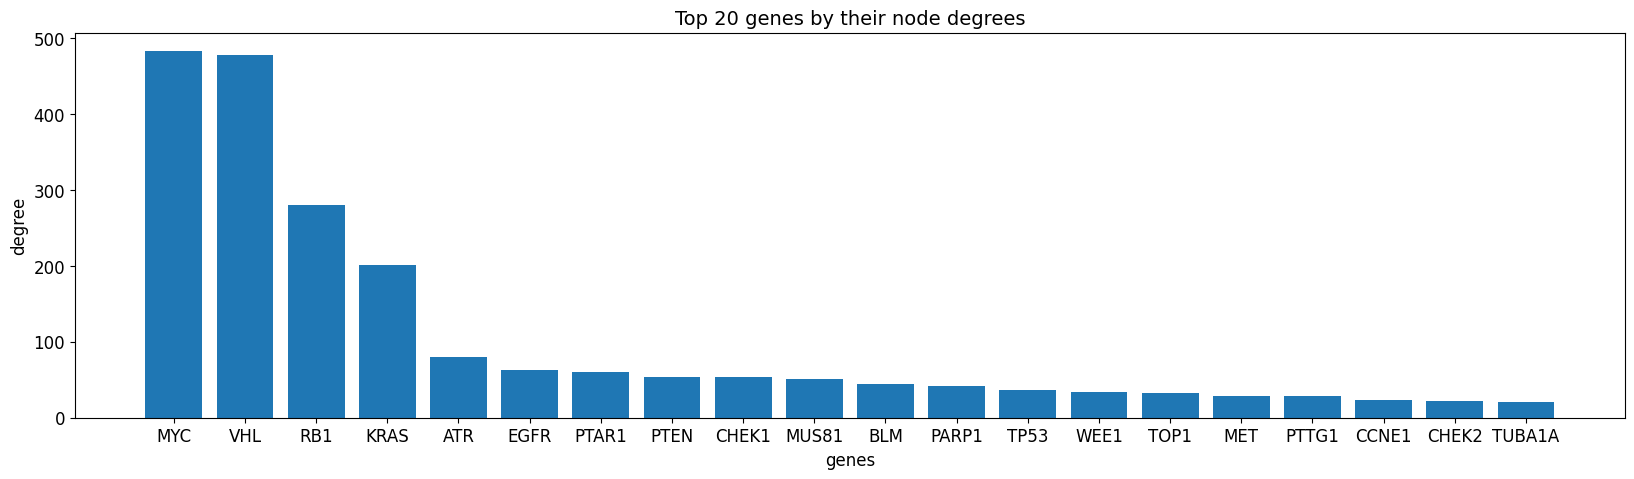

In [19]:
top20_df = node_degree_df.head(20)

plt.figure(figsize=(20,5))
plt.bar(top20_df['node'],top20_df['degree'])
plt.xlabel('genes')
plt.ylabel('degree')
plt.title("Top 20 genes by their node degrees")
plt.show()

<h2>Characterize the node degree distributation of the SLDB graph</h2>
<p>Power laws are probability distributions with the form: p(x) ~ &alpha; x<sup>^{-k}</sup>.</p>
<p>We will use the powerlaw package from 
<a href ="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3906378/" target=__blank>Alstott, et al., 2014</a>.</p>

In [20]:
import powerlaw 
fit = powerlaw.Fit(node_degrees, discrete=True, estimate_discrete=False) 
alpha = fit.power_law.alpha
sigma = fit.power_law.sigma
print(f"Alpha: {alpha}")
print(f"Sigma: {sigma}")

Calculating best minimal value for power law fit
Alpha: 2.5033068518252097
Sigma: 0.035681939967666075


/home/peter/GIT/negativeExampleSelection/venv/lib/python3.10/site-packages/powerlaw.py:1195: RuntimeWarning: divide by zero encountered in double_scalars
  C = 1.0/C
/home/peter/GIT/negativeExampleSelection/venv/lib/python3.10/site-packages/powerlaw.py:840: RuntimeWarning: invalid value encountered in multiply
  likelihoods = f*C


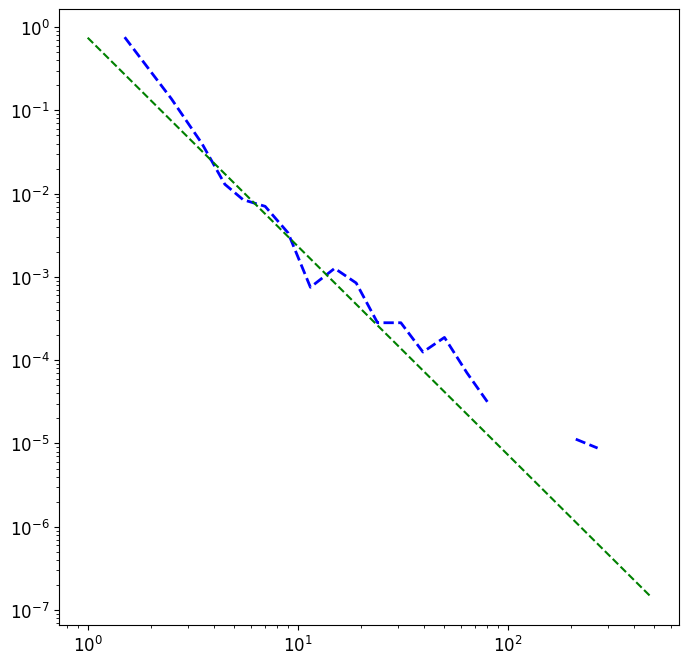

In [21]:
plt.figure(figsize=(8,8))
fig_pdf = fit.plot_pdf(color='b', linestyle='--', linewidth=2)
fit.power_law.plot_pdf(color='g', linestyle='--', ax=fig_pdf)
plt.show();

<h2>Compare power_law distribution with other distributations.</h2>
<p>R is the likelihood ratio between the two candidate distributions. 
<b>R</b> will  be positive if the data is more likely in the first distribution, and negative if the data is more likely in the second distribution. The significance value for that direction is p. According this this analysis, the best fit of the data is with the log normal distribution, but the difference between scale free and log normal is not significant.</p>

In [22]:
R, p = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print (R, p)

4.399848924860831 1.0832626695406321e-05


In [23]:
R, p = fit.distribution_compare('power_law', 'lognormal', normalized_ratio=True)
print (R, p)

-1.030471628887819 0.30278866376786506


/home/peter/GIT/negativeExampleSelection/venv/lib/python3.10/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in divide
  return likelihoods/norm


In [24]:
R, p = fit.distribution_compare('power_law', 'stretched_exponential', normalized_ratio=True)
print (R, p)

3.243955472819516 0.001178821726203094


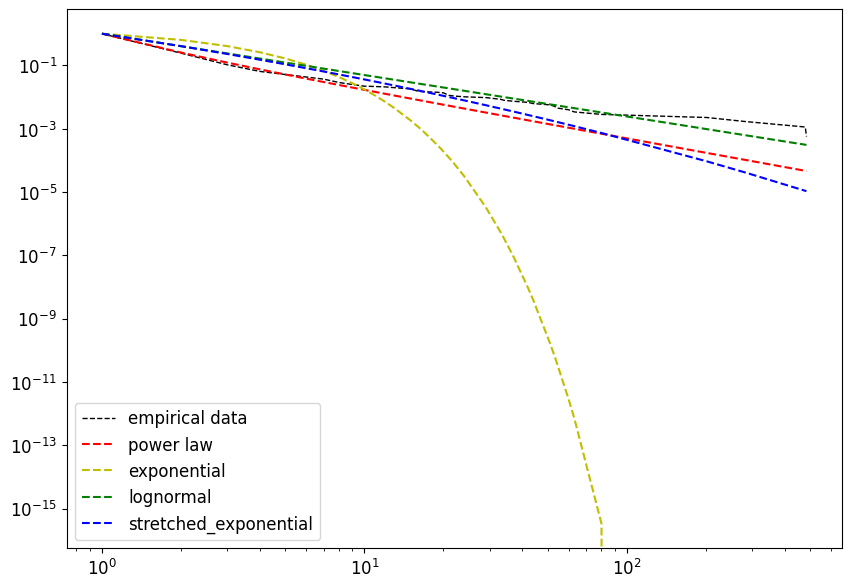

In [25]:
plt.figure(figsize=(10, 7))
fig_comparisons = fit.plot_ccdf(linewidth=1, color='black', linestyle='--', label = "empirical data")
fit.power_law.plot_ccdf(ax=fig_comparisons, color='r', linestyle='--', label = "power law") #powerlaw
fit.exponential.plot_ccdf(ax=fig_comparisons, color='y', linestyle='--', label= "exponential") #exponential
fit.lognormal.plot_ccdf(ax=fig_comparisons, color='g', linestyle='--', label = "lognormal") #lognormal
fit.stretched_exponential.plot_ccdf(ax=fig_comparisons, color='b', linestyle='--', label= "stretched_exponential") #stretched_exponential
plt.legend();
# plt.savefig("scale_free.pdf")

<h1>Visualizing the SLI graph</h1>
<p>We use networkx for visualization. The following code converts the GraPE graph into networkx format for visualization. We display only the largest connected component of the SLI graph.</p>

In [26]:
import networkx as nx
from networkx.algorithms import community 
from grape.utils.networkx_utils import convert_ensmallen_graph_to_networkx_graph

In [27]:
G = convert_ensmallen_graph_to_networkx_graph(sli_graph)
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(Gcc[0])
degree_dict = dict(G.degree(G.nodes()))
gene_list_degree_more_one = defaultdict()
nx.set_node_attributes(G, degree_dict, 'degree')
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)
n=0
for gene in degree_dict.keys():
    if degree_dict[gene] > 1:
        n = n+1
        gene_list_degree_more_one[gene] = degree_dict[gene]
print(f"number of genes in SLI graph with degree greater than one: {n}")  

number of genes in SLI graph with degree greater than one: 431


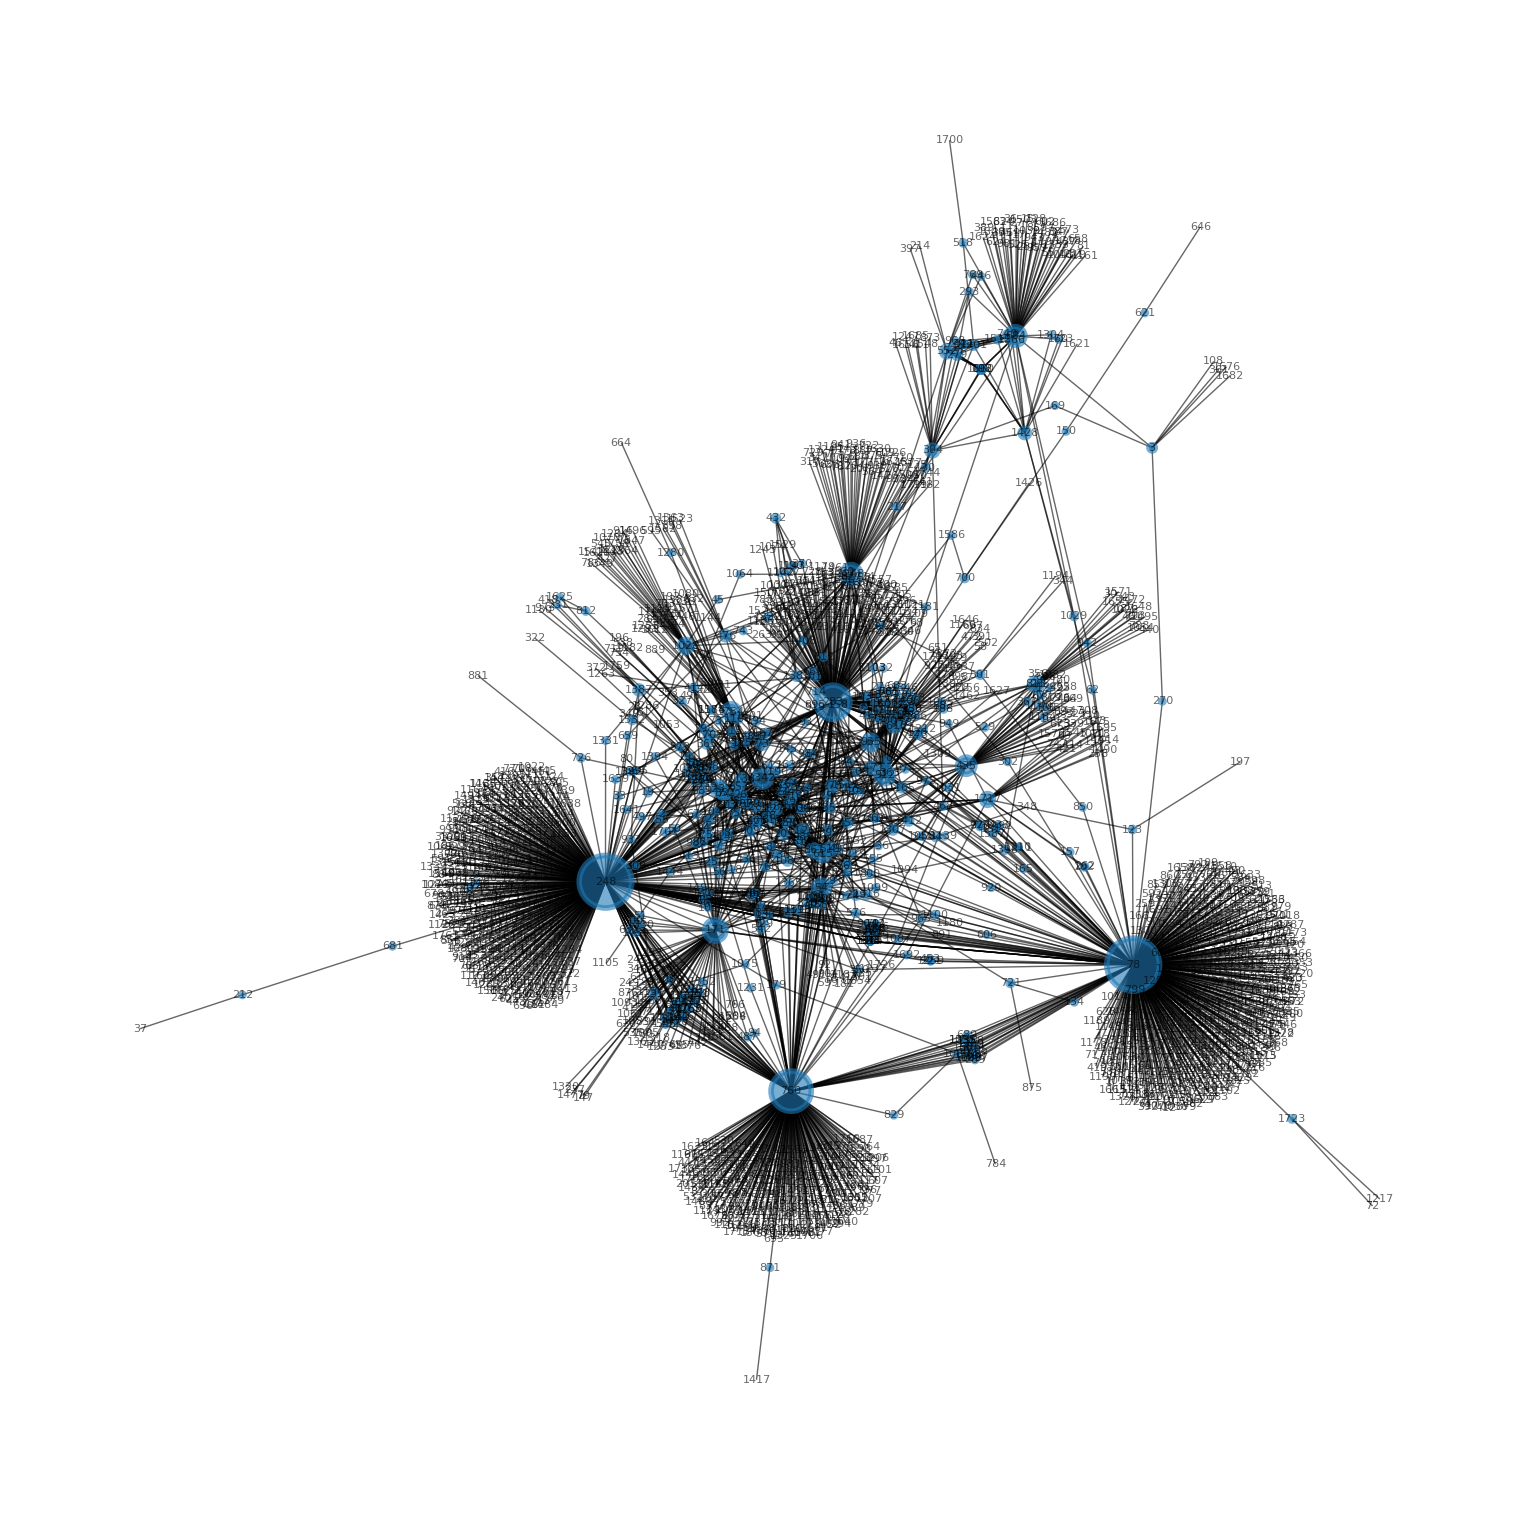

In [28]:
fig_degree_more_one= plt.figure(figsize=(15,15))
nx.draw(G, with_labels=True, nodelist=gene_list_degree_more_one.keys(), 
        node_size=[v * 3 for v in gene_list_degree_more_one.values()],
        alpha =0.6, linewidths=4, font_size =8)
# plt.savefig('slinnetwork.pdf') ;
plt.show();